# Figure 1 Tumor and MDSC Dynamics in Untreated B16F10 Model

## Environment

In [1]:
from scipy.integrate import odeint
from scipy.optimize import differential_evolution

In [2]:
%run 00_data_preprocessing.ipynb

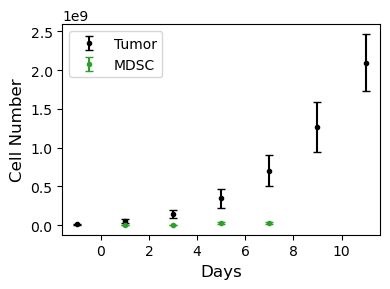

In [3]:
plt.figure(figsize=(4, 3))
plt.errorbar(unt_v_days, unt_v_data, yerr=unt_v_std, fmt='o', capsize=3, markersize=3, color='black', label='Tumor')
plt.errorbar(unt_mdsc['day'], unt_mdsc['N_mean'], yerr=unt_mdsc['N_std'], fmt='o', capsize=3, markersize=3, color='tab:green',label='MDSC')
plt.xlabel('Days', fontsize=12)
plt.ylabel('Cell Number', fontsize=12)
#plt.title('Untreated')
#plt.yscale('log')
plt.legend()
plt.tight_layout()

# ODE model of B16F10 tumor
$$\frac{dV}{dt} = v_r \cdot V \cdot \log{\frac{v_k}{V}}$$

In [4]:
# Gompertz model
def gompertz_model(V, t, r, K):
    return r * V * np.log(K / V)
def gompertz_solve(t, r, K, V0):
    return odeint(gompertz_model, V0, t, args=(r, K)).ravel()

# Loss function
def loss_b16(params, model_solve, time_data, mean_volume_data, std_dev_data):
    V0 = mean_volume_data[0]
    model_pred = model_solve(time_data, *params, V0)
    return np.sum(((mean_volume_data - model_pred) / std_dev_data) ** 2)

# Parameter optimization function
def opt_params(model_solve, bounds, time_data, mean_volume_data, std_dev_data):
    result = differential_evolution(loss_b16, bounds, args=(model_solve, time_data, mean_volume_data, std_dev_data))
    return result.x

In [5]:
# parameter optimization
gompertz_bounds = [(0, 1), (1e9, 1e12)]

params_gompertz = differential_evolution(
                    loss_b16, gompertz_bounds, 
                    args=(gompertz_solve, unt_v_days, unt_v_data, unt_v_std),
                    strategy='best1bin', 
                    maxiter=1000, popsize=50, seed=12
)

print(f"Tumor param:{params_gompertz}")

Tumor param: message: Optimization terminated successfully.
 success: True
     fun: 0.025871162606273198
       x: [ 9.752e-02  1.968e+10]
     nit: 34
    nfev: 3599


In [6]:
v_r, v_k = params_gompertz.x
print("v_r =", v_r)
print("v_k =", v_k)

v_r = 0.09752468467875591
v_k = 19676068012.200745


# 誤差関数

In [7]:
gompertz_bounds = [(0, 1), (1e9, 1e12)]  # r, K の範囲

# ===== ヒートマップを作るための関数 =====
def compute_loss_grid(model_solve,
                      bounds,
                      time_data,
                      mean_volume_data,
                      std_dev_data,
                      n_r=50,
                      n_K=50):
    """
    r-K 平面上のグリッドで loss_b16 を計算
    """
    # r は線形に、K は桁が大きいので対数スケールでサンプリング
    r_min, r_max = bounds[0]
    K_min, K_max = bounds[1]

    r_vals = np.linspace(r_min, r_max, n_r)
    K_vals = np.logspace(np.log10(K_min), np.log10(K_max), n_K)

    loss_grid = np.zeros((n_K, n_r))

    for i, K in enumerate(K_vals):
        for j, r in enumerate(r_vals):
            params = (r, K)
            loss_grid[i, j] = loss_b16(
                params,
                model_solve,
                time_data,
                mean_volume_data,
                std_dev_data
            )

    return r_vals, K_vals, loss_grid

In [8]:
# グリッド計算
r_vals, K_vals, loss_grid = compute_loss_grid(
    gompertz_solve,
    gompertz_bounds,
    unt_v_days, unt_v_data, unt_v_std,
    n_r=100,   # 解像度はお好みで
    n_K=100
)

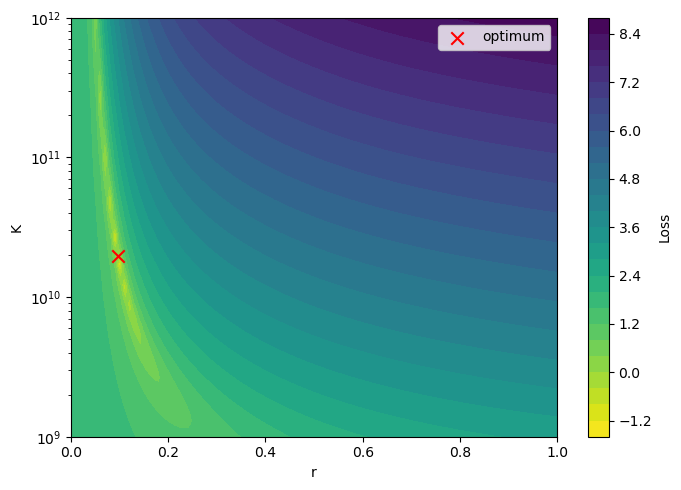

In [9]:
log_loss_grid = np.log10(loss_grid)
# r-K 平面上にヒートマップ表示
R, K = np.meshgrid(r_vals, K_vals)

plt.figure(figsize=(7, 5))
contour = plt.contourf(R, K, log_loss_grid, levels=30, cmap="viridis_r")
plt.yscale('log')  # K は対数スケールにすると見やすい

plt.xlabel("r")
plt.ylabel("K")
cbar = plt.colorbar(contour)
cbar.set_label("Loss")

# 最適解をヒートマップ上にプロット（コメントアウトを外すと表示）
plt.scatter(v_r, v_k, marker="x", color="red", s=80, label="optimum")
plt.legend()

plt.tight_layout()
plt.show()

## Fitting Simulation

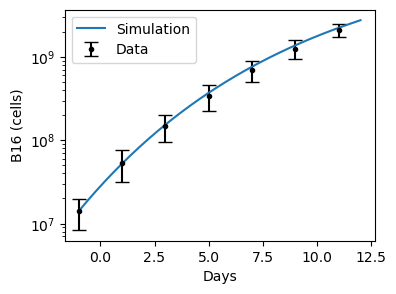

In [10]:
# Simulation
time_sim = np.arange(-1, 12.1, 0.1)
fit_gompertz = gompertz_solve(time_sim, 0.1, 2e10, unt_v_data[0])

# Plotting
plt.figure(figsize=(4, 3))
plt.errorbar(unt_v_days, unt_v_data, yerr=unt_v_std, fmt='o', 
             label='Data', capsize=5, markersize=3,color='black')
plt.plot(time_sim, fit_gompertz, '-', color='tab:blue', label=f'Simulation')
plt.xlabel('Days')
plt.ylabel('B16 (cells)')
plt.yscale('log')
plt.legend()
plt.show()

# ODE model of B16F10 cells and MDSC
\begin{align}
\frac{dV}{dt} &= v_r \cdot V \cdot \log\left(\frac{v_k}{V}\right) \\
\frac{dM}{dt} &= m_v \cdot V - m_d \cdot M
\end{align}

## Model construction

In [11]:
m_d = 0.35
# model
def tumor_mdsc_model(y, t, v_r, v_k, m_v, m_d):
    V, M = y
    dVdt = v_r * V * np.log(v_k / V)
    dMdt = m_v * V - m_d * M
    return [dVdt, dMdt]

# loss function
def loss_b16_mdsc(params):
    m_v = params[0]
    sol = odeint(tumor_mdsc_model, [V0, M0], t_fit, args=(v_r, v_k, m_v, m_d))
    M_sim = sol[:, 1]
    M_fit = M_sim[1:]
    residuals = (M_fit - mdsc_exp) / mdsc_std
    return np.sum(residuals**2)

In [12]:
# Initial values
V0 = unt_v_data[0]
M0 = unt_mdsc_data[0]

# Experimental data for fitting
t_fit = np.array([-1, 1, 3, 5, 7])
mdsc_exp = unt_mdsc_data[1:]
mdsc_std = unt_mdsc_std[1:]

In [13]:
bounds = [(1e-3, 1)]

# differential evolution
params_unt_mdsc = differential_evolution(
            loss_b16_mdsc, bounds, 
            strategy='best1bin', 
            maxiter=1000, popsize=15, seed=12
)

In [14]:
m_v = params_unt_mdsc.x[0]
print("m_v =", m_v)
print("m_d =", m_d)

m_v = 0.029960236019085446
m_d = 0.35


## Simulation

In [15]:
dir_path = "results/figures/section1/fig1"
os.makedirs(dir_path, exist_ok=True)

In [16]:
from matplotlib.ticker import ScalarFormatter

def set_scientific_yticks(ax):
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

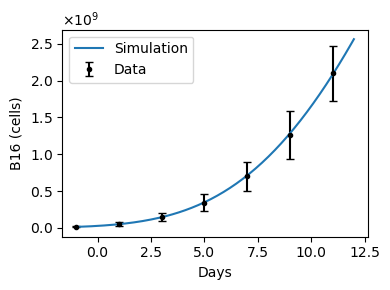

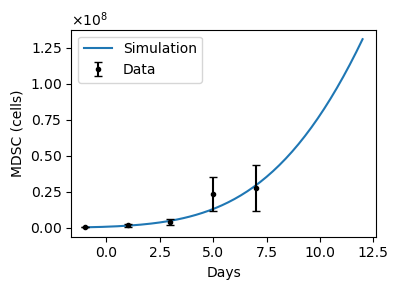

In [17]:
sol = odeint(tumor_mdsc_model, [V0, M0], time_sim, args=(v_r, v_k, m_v, m_d))
V_sol, M_sol = sol.T

# --- Figure 1A: Tumor volume ---
fig, ax = plt.subplots(figsize=(4, 3))
ax.errorbar(unt_v_days, unt_v_data, yerr=unt_v_std, fmt='o',
             capsize=3, markersize=3, color='black', label='Data')
ax.plot(time_sim, V_sol, label='Simulation', color='tab:blue')
ax.set_xlabel('Days')
ax.set_ylabel('B16 (cells)')

set_scientific_yticks(ax)

ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(dir_path, 'fig1a.pdf'), dpi=300)

# --- Figure 1B: MDSC ---
fig2, ax2 = plt.subplots(figsize=(4, 3))
ax2.plot(time_sim, M_sol, label='Simulation', color='tab:blue')
ax2.errorbar(unt_mdsc_days, unt_mdsc_data, yerr=unt_mdsc_std, fmt='o',
              capsize=3, markersize=3, color='black', label='Data')
ax2.set_xlabel('Days')
ax2.set_ylabel('MDSC (cells)')
#ax2.set_yscale('log')

set_scientific_yticks(ax2)

ax2.legend()
fig2.tight_layout()
fig2.savefig(os.path.join(dir_path, 'fig1b.pdf'), dpi=1200)